## OSMnx and Networkx Exploration
### Urban Renewal Explorer - Exploratory Analysis

### Background
In my aerial imagery work, I created a way to digitize some historic streets into geojson format. Below, I do the following:

- Process the geojson to make sure it has intersection nodes and visualize
- Visualize a bounding box around Kenyon-Barr in the West End (before and after urban renewal)
- Do a simple network analysis of some of the connectivity loss

In [28]:
# Setup
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import unary_union, split
from shapely.geometry import box
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

In [24]:
print("Loading historical streets...")
historical = gpd.read_file('../data/streets/cincinnati_kenyon_barr_streets.geojson')

if historical.crs is None:
    historical = historical.set_crs('EPSG:4326')


print("\nFinding intersection points...")
intersections = []
for i, street1 in historical.iterrows():
    for j, street2 in historical.iterrows():
        if i >= j:
            continue

        if street1.geometry.intersects(street2.geometry):
            intersection = street1.geometry.intersection(street2.geometry)

            if intersection.geom_type == 'Point':
                intersections.append(intersection)
            elif intersection.geom_type == 'MultiPoint':
                intersections.extend(list(intersection.geoms))
            elif intersection.geom_type == 'LineString':
                coords = list(intersection.coords)
                intersections.append(Point(coords[0]))
                intersections.append(Point(coords[-1]))


print("\nAdding street endpoints...")
endpoints = []
for idx, street in historical.iterrows():
    coords = list(street.geometry.coords)
    endpoints.append(Point(coords[0]))   # Start point
    endpoints.append(Point(coords[-1]))  # End point

all_nodes = intersections + endpoints


print("\nRemoving duplicate nodes...")
nodes_gdf = gpd.GeoDataFrame(geometry=all_nodes, crs='EPSG:4326')
tolerance = 0.00001  # approximately 1 meter
unique_nodes = []
used = set()

for i, node1 in nodes_gdf.iterrows():
    if i in used:
        continue
    nearby = nodes_gdf[nodes_gdf.distance(node1.geometry) < tolerance]
    if len(nearby) > 1:
        centroid = MultiPoint(list(nearby.geometry)).centroid
        unique_nodes.append(centroid)
    else:
        unique_nodes.append(node1.geometry)
    used.update(nearby.index)


nodes_final = gpd.GeoDataFrame(
    {'node_id': range(len(unique_nodes))},
    geometry=unique_nodes,
    crs='EPSG:4326'
)
nodes_final['x'] = nodes_final.geometry.x
nodes_final['y'] = nodes_final.geometry.y


nodes_final.to_file('../data/streets/historical_intersection_nodes.geojson', driver='GeoJSON')

Loading historical streets...

Finding intersection points...

Adding street endpoints...

Removing duplicate nodes...


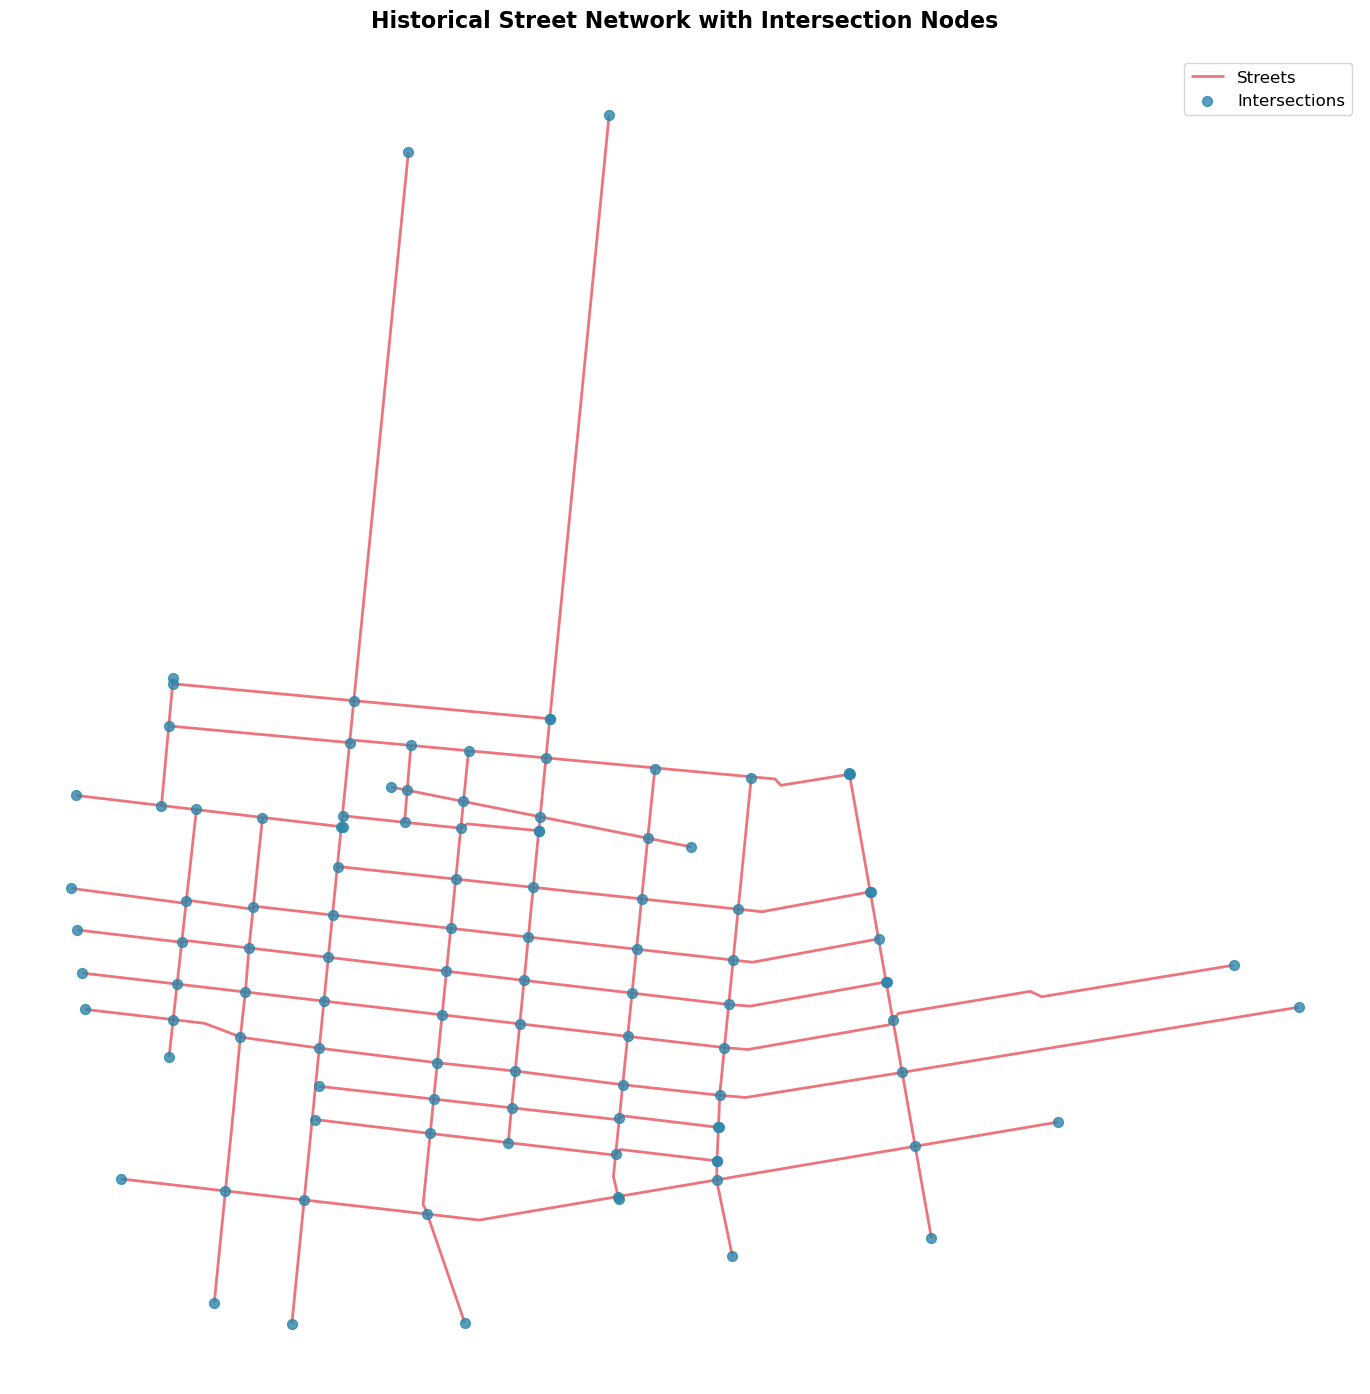

In [25]:
fig, ax = plt.subplots(figsize=(14, 14))

# Plot streets
historical.plot(ax=ax, color='#E63946', linewidth=2, alpha=0.7, label='Streets')

# Plot intersection nodes
nodes_final.plot(ax=ax, color='#2E86AB', markersize=50, alpha=0.8,
                 label='Intersections', zorder=5)

ax.set_title('Historical Street Network with Intersection Nodes',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.savefig('osmnx-output/historical_network_with_nodes.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

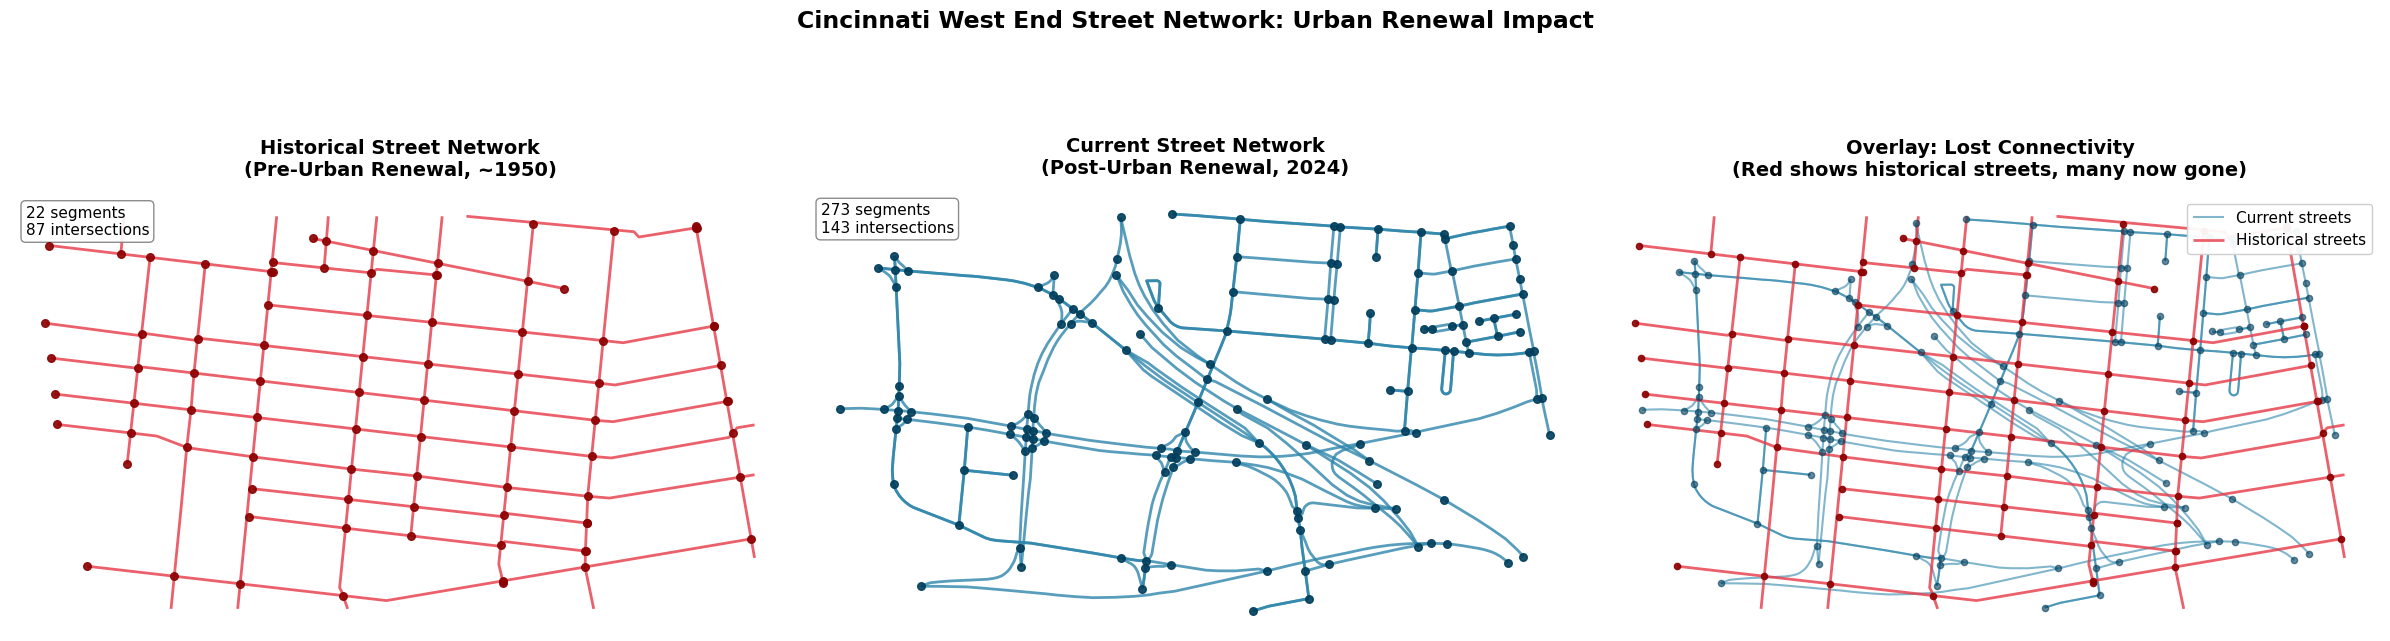

In [29]:
historical = gpd.read_file('../data/streets/cincinnati_kenyon_barr_streets.geojson')
historical_nodes = gpd.read_file('../data/streets/historical_intersection_nodes.geojson')

if historical.crs is None:
    historical = historical.set_crs('EPSG:4326')
if historical_nodes.crs is None:
    historical_nodes = historical_nodes.set_crs('EPSG:4326')

historical = historical[~historical.geometry.isna()].copy()
historical = historical[~historical.is_empty].copy()
historical = historical[historical.is_valid].copy()
north = 39.1080
south = 39.1003
east = -84.5200
west = -84.5380
bbox = box(west, south, east, north)

original_count = len(historical)
historical = historical[historical.intersects(bbox)].copy()
historical['geometry'] = historical.geometry.intersection(bbox)
historical = historical[~historical.is_empty].copy()
historical_nodes = historical_nodes[historical_nodes.intersects(bbox)].copy()


try:
    current_graph = ox.graph_from_bbox(north, south, east, west, network_type='drive')
except Exception as e:
    raise
current_nodes, current_edges = ox.graph_to_gdfs(current_graph)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))


historical.plot(ax=ax1, color='#E63946', linewidth=2, alpha=0.8)
historical_nodes.plot(ax=ax1, color='#8B0000', markersize=30, alpha=0.9, zorder=5)
ax1.set_title('Historical Street Network\n(Pre-Urban Renewal, ~1950)',
              fontsize=14, fontweight='bold', pad=15)
ax1.axis('off')
ax1.text(0.02, 0.98, f'{len(historical)} segments\n{len(historical_nodes)} intersections',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

current_edges.plot(ax=ax2, color='#2E86AB', linewidth=2, alpha=0.8)
current_nodes.plot(ax=ax2, color='#003D5B', markersize=30, alpha=0.9, zorder=5)
ax2.set_title('Current Street Network\n(Post-Urban Renewal, 2024)',
              fontsize=14, fontweight='bold', pad=15)
ax2.axis('off')
ax2.text(0.02, 0.98, f'{len(current_edges)} segments\n{len(current_nodes)} intersections',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))


current_edges.plot(ax=ax3, color='#2E86AB', linewidth=1.5, alpha=0.6, label='Current streets')
current_nodes.plot(ax=ax3, color='#003D5B', markersize=20, alpha=0.6, zorder=4)
historical.plot(ax=ax3, color='#E63946', linewidth=2, alpha=0.8, label='Historical streets')
historical_nodes.plot(ax=ax3, color='#8B0000', markersize=20, alpha=0.9, zorder=5)
ax3.set_title('Overlay: Lost Connectivity\n(Red shows historical streets, many now gone)',
              fontsize=14, fontweight='bold', pad=15)
ax3.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax3.axis('off')


plt.suptitle('Cincinnati West End Street Network: Urban Renewal Impact',
             fontsize=17, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('osmnx-output/street_network_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [31]:
G_historical = nx.Graph()

for idx, node in historical_nodes.iterrows():
    G_historical.add_node(idx, pos=(node.geometry.x, node.geometry.y))

tolerance = 0.0001

for idx, street in historical.iterrows():
    connected_nodes = []
    for node_idx, node in historical_nodes.iterrows():
        if street.geometry.distance(node.geometry) < tolerance:
            connected_nodes.append(node_idx)

    if len(connected_nodes) >= 2:
        for i in range(len(connected_nodes) - 1):
            G_historical.add_edge(connected_nodes[i], connected_nodes[i+1])

print(f"Historical: {G_historical.number_of_nodes()} nodes, {G_historical.number_of_edges()} edges")
print(f"Current: {current_graph.number_of_nodes()} nodes, {current_graph.number_of_edges()} edges")


lost_intersections = len(historical_nodes) - len(current_nodes)
lost_pct = (lost_intersections / len(historical_nodes)) * 100

hist_density = nx.density(G_historical)
curr_density = nx.density(current_graph)
density_change_pct = ((curr_density - hist_density) / hist_density) * 100

results_df = pd.DataFrame({
    'Metric': ['Intersections', 'Network Density'],
    'Historical': [len(historical_nodes), f'{hist_density:.3f}'],
    'Current': [len(current_nodes), f'{curr_density:.3f}'],
    'Change': [f'{lost_intersections} ({lost_pct:.0f}%)', f'{density_change_pct:.0f}%']
})

print("\n")
print(results_df.to_string(index=False))
print("\n" + "="*70)

with open("osmnx-output/networkx.html", "w") as f:
    f.write(results_df.to_html())

Historical: 87 nodes, 143 edges
Current: 143 nodes, 273 edges


         Metric Historical Current     Change
  Intersections         87     143 -56 (-64%)
Network Density      0.038   0.013       -65%

